# NN Classification

## Making some data

In [4]:
from PIL.ImageColor import colormap
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000
# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [5]:
len(X), len(y)

(1000, 1000)

In [6]:
print(f"First five of X:\n {X[:5]}")
print(f"First five of y:\n {y[:5]}")

First five of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First five of y:
 [1 1 1 1 0]


In [7]:
# Make DataFrame of circle data
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0],
                        "X2:": X[:, 1],
                        "label": y})
circles.head(10)

,X1,X2:,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


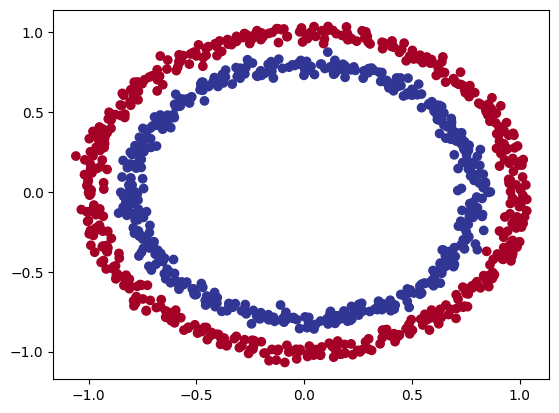

In [8]:
# Visualize
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [9]:
# Check input / output shapes
X.shape, y.shape

((1000, 2), (1000,))

In [10]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
shapes for one sample of X: (2,) and the same for y: ()


In [11]:
import torch

torch.__version__

'2.7.0+cpu'

In [12]:
# Turn into tensors and create train and test split
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [13]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [14]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## Building the Model

In [15]:
import torch
from torch import nn

# Setup device agnostic code (optional)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [16]:
# Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # Create 2 nn.Linear() layers capable of handling our data's shapes
        self.layer_1 = nn.Linear(in_features=2,
                                 out_features=5)  # takes in 2 features, upscales to 5
        self.layer_2 = nn.Linear(in_features=5,
                                 out_features=1)  # takes the upscaled 5 features, outputs 1 feature (same shape as y)

    # Define forward method, outlining the forward pass
    def forward(self, x):
        return self.layer_2(self.layer_1(x))  # Goes into layer_1, output passed into layer_2


model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
# Lets replicate the above model using nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.Linear(in_features=8, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=1, bias=True)
)

In [18]:
# Make some predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of preds: {len(untrained_preds)}, shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, shape: {X_test.shape}")
print(f"\nFirst 10 preds:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of preds: 200, shape: torch.Size([200, 1])
Length of test samples: 200, shape: torch.Size([200, 2])

First 10 preds:
tensor([[-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.]])

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [19]:
# Pick loss function
loss_fn = nn.BCEWithLogitsLoss()  # has the sigmoid activation function built in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [20]:
# Calc accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [21]:
# View the first 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
print(y_logits)
print(y_test[:5])

tensor([[-0.3595],
        [-0.3014],
        [-0.3849],
        [-0.3529],
        [-0.1831]], grad_fn=<SliceBackward0>)
tensor([1., 0., 1., 0., 1.])


In [22]:
# Through activation func
y_pred_probs = torch.sigmoid(y_logits)
print(y_pred_probs)

tensor([[0.4111],
        [0.4252],
        [0.4049],
        [0.4127],
        [0.4544]], grad_fn=<SigmoidBackward0>)


In [23]:
y_preds = torch.round(y_pred_probs)

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

In [24]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [25]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 2000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### TRAINING
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))  # turn logits into pred probs into pred labels

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    ### TESTING
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    if epoch % 10 == 0:
        print(
            f"Epoch nr: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch nr: 0 | Loss: 0.70383, Acc: 50.00% | Test loss: 0.70398, Test acc: 50.00%
Epoch nr: 10 | Loss: 0.69700, Acc: 44.62% | Test loss: 0.69741, Test acc: 44.00%
Epoch nr: 20 | Loss: 0.69496, Acc: 47.12% | Test loss: 0.69529, Test acc: 46.00%
Epoch nr: 30 | Loss: 0.69426, Acc: 49.88% | Test loss: 0.69449, Test acc: 45.00%
Epoch nr: 40 | Loss: 0.69395, Acc: 50.00% | Test loss: 0.69414, Test acc: 43.50%
Epoch nr: 50 | Loss: 0.69378, Acc: 50.12% | Test loss: 0.69395, Test acc: 46.50%
Epoch nr: 60 | Loss: 0.69365, Acc: 50.00% | Test loss: 0.69384, Test acc: 48.50%
Epoch nr: 70 | Loss: 0.69355, Acc: 49.75% | Test loss: 0.69377, Test acc: 49.00%
Epoch nr: 80 | Loss: 0.69347, Acc: 50.12% | Test loss: 0.69374, Test acc: 50.50%
Epoch nr: 90 | Loss: 0.69340, Acc: 49.50% | Test loss: 0.69372, Test acc: 50.00%
Epoch nr: 100 | Loss: 0.69335, Acc: 49.38% | Test loss: 0.69371, Test acc: 51.50%
Epoch nr: 110 | Loss: 0.69330, Acc: 49.62% | Test loss: 0.69372, Test acc: 50.50%
Epoch nr: 120 | Loss: 0.693

## downloading helper_functions

In [26]:
import requests
from pathlib import Path

# Download helper funcs
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("downloading helper_funcitons.py")
    request = requests.get(
        "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


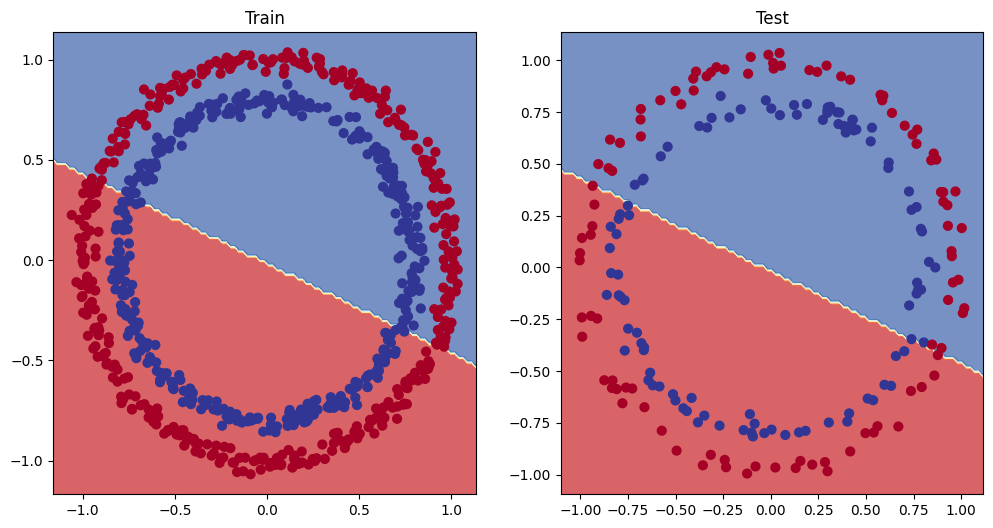

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## Improving a model
* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units (same principle as above)
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

In [28]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 16)
        self.layer_2 = nn.Linear(16, 16)
        self.layer_3 = nn.Linear(16, 1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))


model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=1, bias=True)
)

In [29]:
# Loss and SGD
loss_fn_1 = nn.BCEWithLogitsLoss()
optimizer_1 = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [30]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()

    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn_1(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer_1.zero_grad()

    loss.backward()

    optimizer_1.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn_1(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69618, Acc: 50.00% | Test loss: 0.69344, Test acc: 50.00%
Epoch: 100 | Loss: 0.69300, Acc: 51.25% | Test loss: 0.69410, Test acc: 46.00%
Epoch: 200 | Loss: 0.69298, Acc: 51.25% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 300 | Loss: 0.69298, Acc: 51.12% | Test loss: 0.69466, Test acc: 46.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%


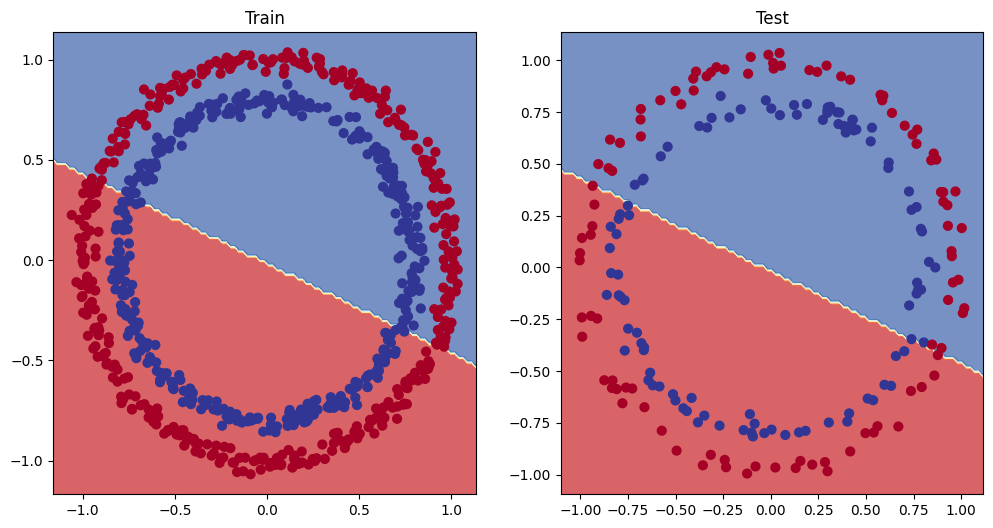

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [32]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

X_regression[:5], y_regression[:5], len(X_regression), len(y_regression)

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]),
 100,
 100)

In [33]:
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

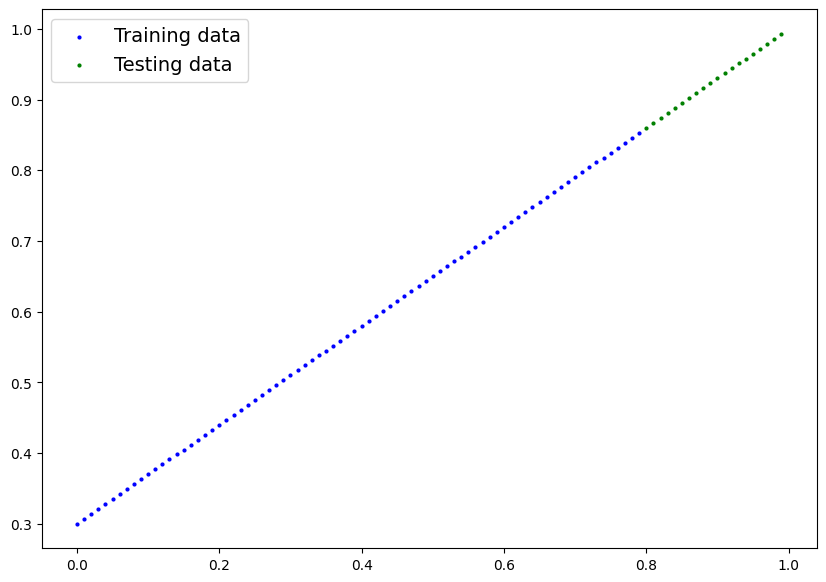

In [34]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

In [35]:
model_2 = nn.Sequential(
    nn.Linear(1, 16),
    nn.Linear(16, 16),
    nn.Linear(16, 1)
).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=16, bias=True)
  (1): Linear(in_features=16, out_features=16, bias=True)
  (2): Linear(in_features=16, out_features=1, bias=True)
)

In [36]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.001)

In [37]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train_regression, X_test_regression, y_train_regression, y_test_regression = X_train_regression.to(
    device), X_test_regression.to(device), y_train_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    model_2.train()
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

    if epoch % 100 == 0:
        print(f"epoch: {epoch} | loss: {loss:.5f} | test loss: {test_loss:.5f}")

epoch: 0 | loss: 0.44708 | test loss: 0.79393
epoch: 100 | loss: 0.09719 | test loss: 0.23254
epoch: 200 | loss: 0.08369 | test loss: 0.19275
epoch: 300 | loss: 0.07038 | test loss: 0.16200
epoch: 400 | loss: 0.05700 | test loss: 0.13129
epoch: 500 | loss: 0.04346 | test loss: 0.10009
epoch: 600 | loss: 0.02967 | test loss: 0.06802
epoch: 700 | loss: 0.01554 | test loss: 0.03548
epoch: 800 | loss: 0.00483 | test loss: 0.00290
epoch: 900 | loss: 0.00560 | test loss: 0.00186


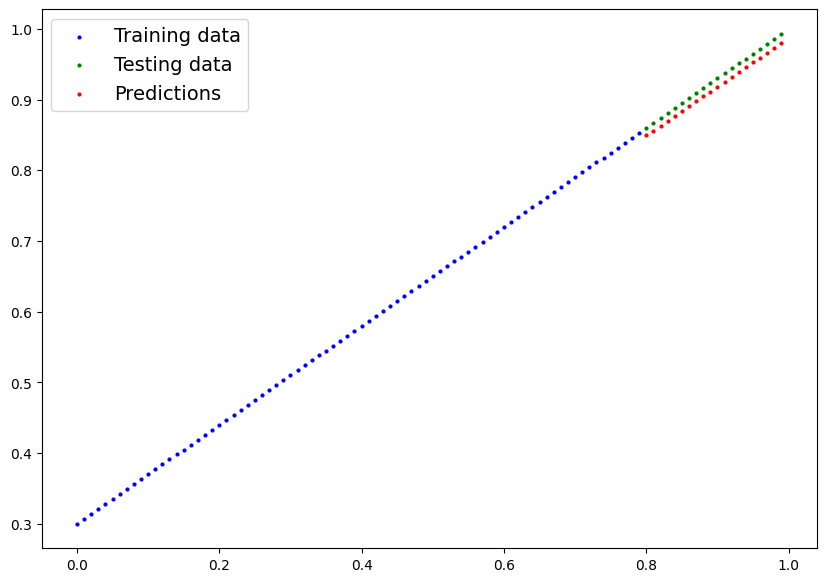

In [38]:
model_2.eval()
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

# Make and plot data

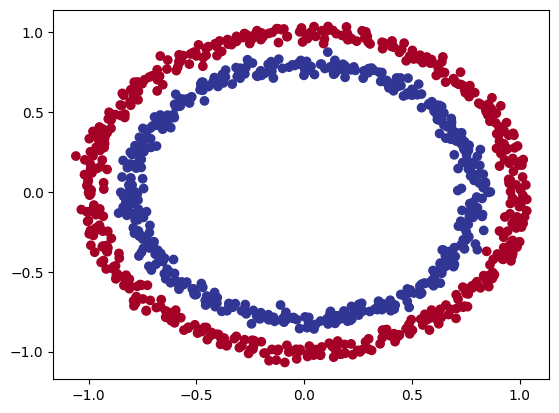

In [39]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [40]:
# Convert data to tensors and then split
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### Building a model with non-linearity

In [41]:
from torch import nn


class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=16)
        self.layer_2 = nn.Linear(in_features=16, out_features=16)
        self.layer_3 = nn.Linear(in_features=16, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

In [42]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

In [43]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 2000

X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    model_3.train()
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #TEST
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    if epoch % 100 == 0:
        print(f"epoch: {epoch} | loss: {loss:.5f}, acc: {acc:.2f}% | test loss: {test_loss}, test acc: {test_acc:.2f}%")

epoch: 0 | loss: 0.69753, acc: 50.00% | test loss: 0.6978390216827393, test acc: 50.00%
epoch: 100 | loss: 0.68987, acc: 56.25% | test loss: 0.6913949847221375, test acc: 51.50%
epoch: 200 | loss: 0.68663, acc: 52.88% | test loss: 0.6887487173080444, test acc: 52.00%
epoch: 300 | loss: 0.68264, acc: 53.62% | test loss: 0.6857616901397705, test acc: 52.50%
epoch: 400 | loss: 0.67735, acc: 54.00% | test loss: 0.6818864941596985, test acc: 53.50%
epoch: 500 | loss: 0.67006, acc: 56.00% | test loss: 0.6763973236083984, test acc: 55.50%
epoch: 600 | loss: 0.65938, acc: 62.38% | test loss: 0.6677736639976501, test acc: 58.00%
epoch: 700 | loss: 0.64168, acc: 75.50% | test loss: 0.6532543897628784, test acc: 68.50%
epoch: 800 | loss: 0.61284, acc: 87.38% | test loss: 0.6288639307022095, test acc: 85.00%
epoch: 900 | loss: 0.56398, acc: 97.25% | test loss: 0.5872284173965454, test acc: 93.00%
epoch: 1000 | loss: 0.48222, acc: 99.25% | test loss: 0.5169848203659058, test acc: 97.00%
epoch: 1100

## Eval

In [44]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

## Visualize

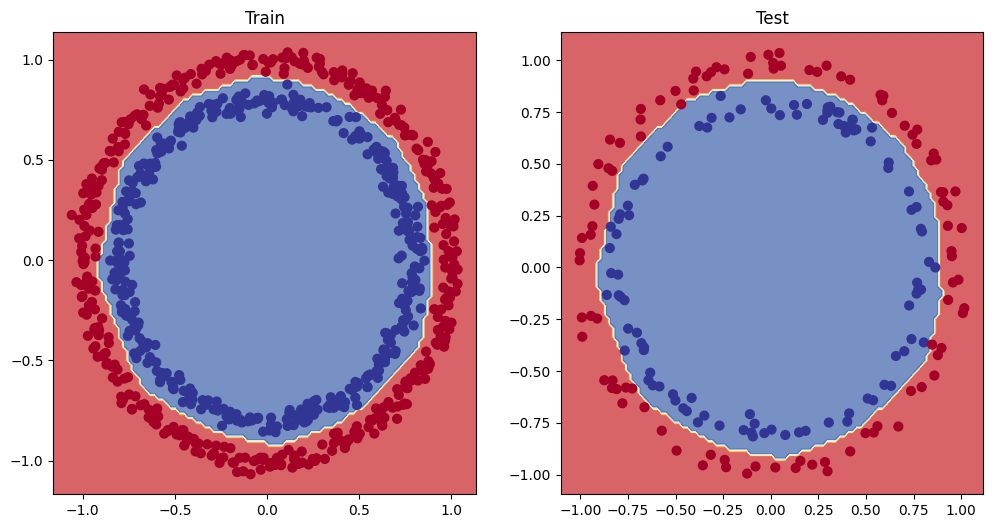

In [45]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

In [46]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

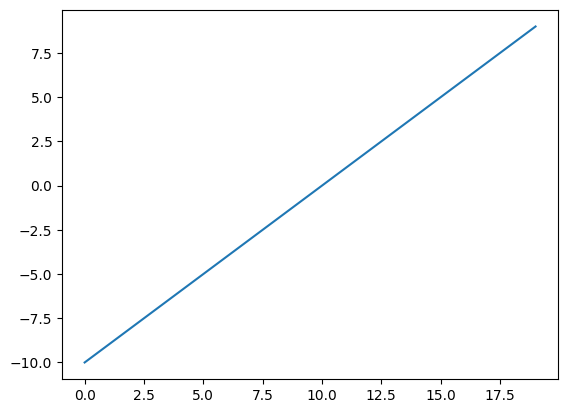

In [47]:
plt.plot(A);

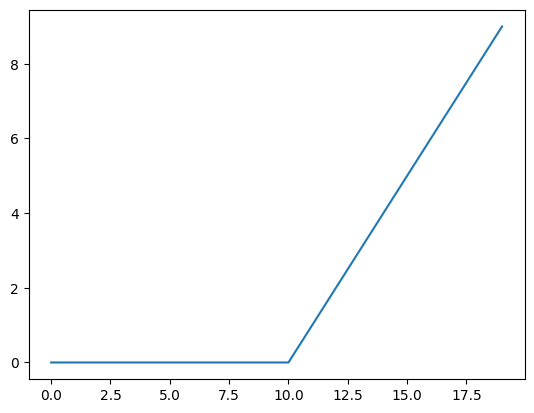

In [48]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.max(torch.tensor(0), x)


plt.plot(relu(A))

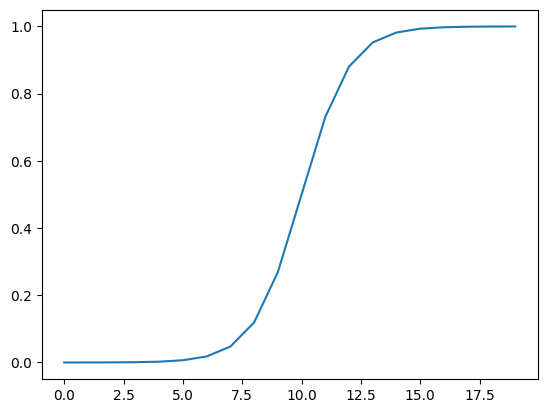

In [49]:
def sigmoid(x: torch.Tensor) -> torch.Tensor:
    return 1 / (1 + torch.exp(-x))


plt.plot(sigmoid(A))

# MULTICLASS PROBLEM

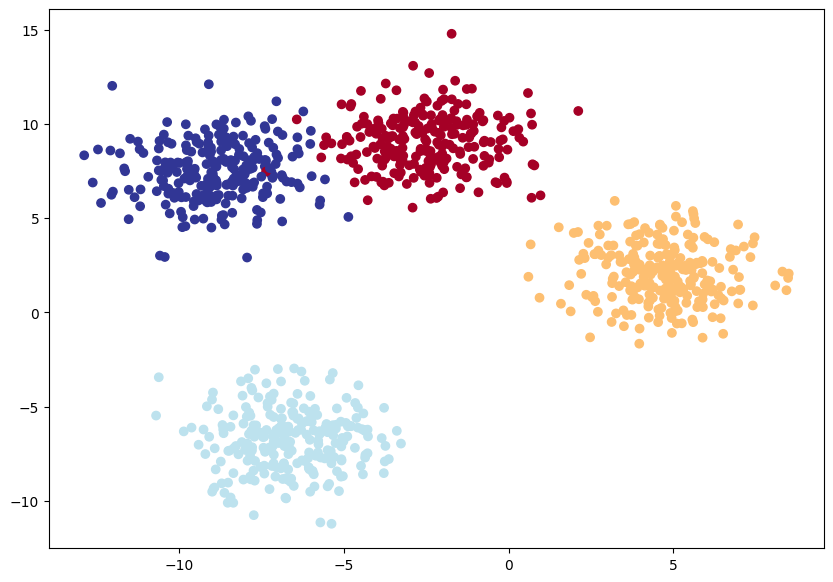

In [72]:
# Creating a toy multiclass dataset
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# set the hyperparams
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# create data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,  # give the clusters a little shakeup
                            random_state=RANDOM_SEED)
# turn into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

# split data
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)
# plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [73]:
X_train[:5]

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        [-0.9666, -0.2256],
        [-0.1666,  0.7994]])

In [74]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """
        Initialized multi-class classification model.

        Args:
            :arg input_features amount of input features
            :arg output_features amount of output features
            :arg hidden_units amount of hidden neurons per layer
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)


model_4 = BlobModel(2, 4, 8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [75]:
# loss and optim
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

In [76]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)
y_logits[:10]

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852],
        [ 2.0878, -1.3728,  2.1248,  2.5052],
        [ 1.8310,  0.8851,  2.1674,  0.6006],
        [ 0.1412, -1.4742, -0.0360,  1.0373],
        [ 2.9426,  0.7047,  3.3670,  1.6184],
        [-0.0645, -1.5006, -0.2666,  0.8940]])

In [77]:
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]])
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]])


In [78]:
# Convert pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([3, 3, 2, 1, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2,
        2, 2, 3, 3, 3, 3, 3, 1, 1, 2, 1, 2, 1, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3,
        3, 3, 1, 3, 3, 1, 3, 2, 3, 1, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 3, 3, 2, 3, 3, 3, 3, 2, 3, 1, 3, 3, 2, 1, 1, 3, 2, 2, 3, 3, 3, 1, 2,
        2, 3, 3, 1, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 1, 1, 3, 2, 2,
        2, 2, 3, 3, 3, 2, 2, 1, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3,
        2, 2, 2, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3, 3,
        1, 3, 2, 3, 3, 1, 2, 3])

In [79]:
# training / testing loop
torch.manual_seed(42)

epochs = 100

for epoch in range(epochs):
    model_4.train()

    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train.type(torch.long))
    acc = accuracy_fn(y_blob_train, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test.type(torch.long))
        test_acc = accuracy_fn(y_blob_test, test_pred)

    if epoch % 10 == 0:
        print(
            f"epoch: {epoch} | loss: {loss:.5f}, acc: {acc:.2f}% | test loss: {test_loss:.5f}, test acc: {test_acc:.2f}%")

epoch: 0 | loss: 1.04324, acc: 65.50% | test loss: 0.57861, test acc: 95.50%
epoch: 10 | loss: 0.14398, acc: 99.12% | test loss: 0.13037, test acc: 99.00%
epoch: 20 | loss: 0.08062, acc: 99.12% | test loss: 0.07216, test acc: 99.50%
epoch: 30 | loss: 0.05924, acc: 99.12% | test loss: 0.05133, test acc: 99.50%
epoch: 40 | loss: 0.04892, acc: 99.00% | test loss: 0.04098, test acc: 99.50%
epoch: 50 | loss: 0.04295, acc: 99.00% | test loss: 0.03486, test acc: 99.50%
epoch: 60 | loss: 0.03910, acc: 99.00% | test loss: 0.03083, test acc: 99.50%
epoch: 70 | loss: 0.03643, acc: 99.00% | test loss: 0.02799, test acc: 99.50%
epoch: 80 | loss: 0.03448, acc: 99.00% | test loss: 0.02587, test acc: 99.50%
epoch: 90 | loss: 0.03300, acc: 99.12% | test loss: 0.02423, test acc: 99.50%


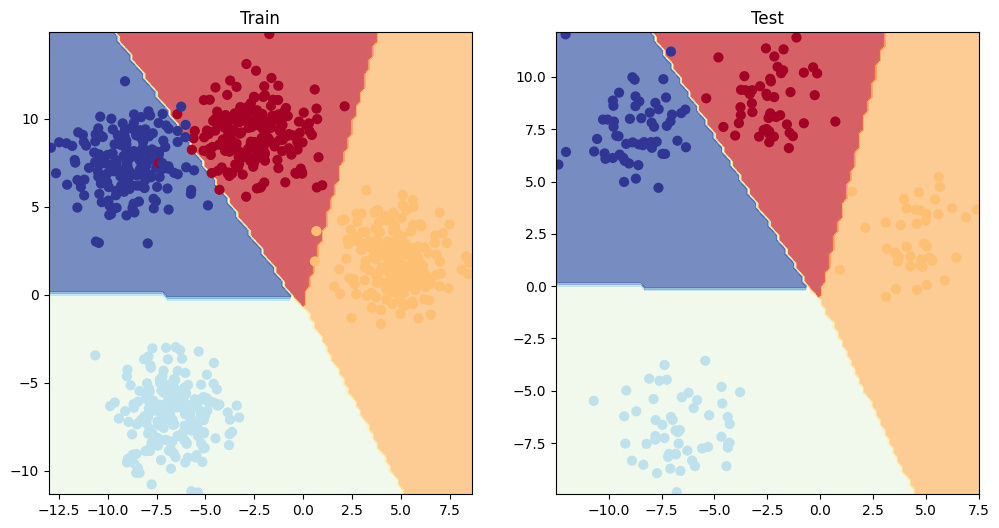

In [80]:
model_4.eval()
with torch.inference_mode():
    y_pred = torch.softmax(model_4(X_blob_test), dim=1).argmax(dim=1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [83]:
from torchmetrics import Accuracy
torchmetric_acc = Accuracy(task="multiclass", num_classes=4)
torchmetric_acc(y_pred, y_blob_test)

tensor(0.9950)